In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch

import visualize as vis

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
def plot_results(dic, m, rng=(), split="valid", lbl="", linestyle="-", fill=True, return_c=True, c=None):
    x = np.arange(len(dic["mean"]["metrics"]["train"][()]["acc"]))
    p = plt.plot(x, dic["mean"]["metrics"][split][rng][m], linestyle=linestyle, label=lbl, color=c)
    if fill:
        plt.fill_between(x, dic["mean"]["metrics"][split][rng][m]-dic["std"]["metrics"][split][rng][m],
                        dic["mean"]["metrics"][split][rng][m]+dic["std"]["metrics"][split][rng][m], alpha=0.3, color=p[0].get_color())
    return p[0].get_color() if return_c else None

In [4]:
os.listdir("results")

['.DS_Store',
 '.ipynb_checkpoints',
 'bls_mono_detections.pkl',
 'bls_monodetections',
 'bls_multi_3it_detections',
 'bls_multi_3it_detections.pkl',
 'bls_multi_3it_outlier_detections',
 'bls_single_detections.pkl',
 'low_risk_flatten_lc.pkl',
 'rnn_mono_detections.pkl',
 'rnn_multi_3it_detections.pkl',
 'rnn_sde_single_detections.pkl',
 'rnn_single_detections.pkl',
 'rnnconf_single_detections.pkl',
 'rnnflat_single_detections.pkl']

## Scaling
Scaling by (white-)noise estimate, standardizing, feeding derivatives

In [ ]:
results = {"mscale0_mode1":'bigru1_w4snr_sim_mscale0_stddize1_mode1_nanmode0.pkl',
           "mscale1_mode1":'bigru1_w4snr_sim_mscale1_stddize1_mode1_nanmode0.pkl',
           "mscale1_mode0":'bigru1_w4snr_sim_mscale1_stddize1_mode0_nanmode0.pkl',
           "mscale0_mode2":'bigru1_w4snr_sim_mscale0_stddize1_mode2_nanmode0.pkl',
           "mscale0_mode3":'bigru1_w4snr_sim_mscale0_stddize1_mode3_nanmode0.pkl'}
for r in results:
    with open("results/preprocessing/"+results[r], "rb") as f:
        results[r] = pickle.load(f)

In [ ]:
dontshow=[]
plt.figure(figsize=(10,4))
for mname in [m for m in results if m not in dontshow]:
    plot_results(results[mname], "acc_seg", split="valid", lbl=mname, fill=1)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show() 

## Data gaps
Simulated gaps, zero-filling, linear interpolation, predicting missing values.

In [ ]:
results = {"nanmode1":'bigru1_w4snr_simgap_mscale1_stddize1_mode1_nanmode1.pkl',
            "nanmode2":'bigru1_w4snr_simgap_mscale1_stddize1_mode1_nanmode2.pkl',
           "nanmode0":'bigru1gen_w4snr_simgap_mscale1_stddize1_mode1_nanmode0.pkl',
           "mscale1_mode1":'bigru1_w4snr_sim_mscale1_stddize1_mode1_nanmode0.pkl'}
for r in results:
    with open("results/preprocessing/"+results[r], "rb") as f:
        results[r] = pickle.load(f)

In [ ]:
dontshow=[]
plt.figure(figsize=(10,4))
for mname in [m for m in results if m not in dontshow]:
    plot_results(results[mname], "tpr", split="valid", lbl=mname, fill=0)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show() 

## Lilith specific
Outlier removal, low-risk detrending (compare vs non-scaled flux segments)

In [92]:
with open("results/low_risk_flatten_lc.pkl", "rb") as f:
    lc = pickle.load(f)

toffs = lc["time"][0]
lc["time"]-=toffs

In [155]:
sigma = np.nanstd(flatten(lc["time"], lc["flux"], method="median", window_length=utils.hour2day(0.5)))
fluxes = [lc["flux"], lc["flat"], np.diff(lc["flux"], prepend=lc["flux"][0])]
fluxes2 = [lc["flux"], np.diff(lc["flux"]/sigma, prepend=lc["flux"][0]),lc["flat"]]
spans = [i-toffs for i in [1321, 1327]]
span_t = utils.min2day(1500 * 2)
cs = [plt.plot([])[0].get_color() for i in range(2)]
plt.close()

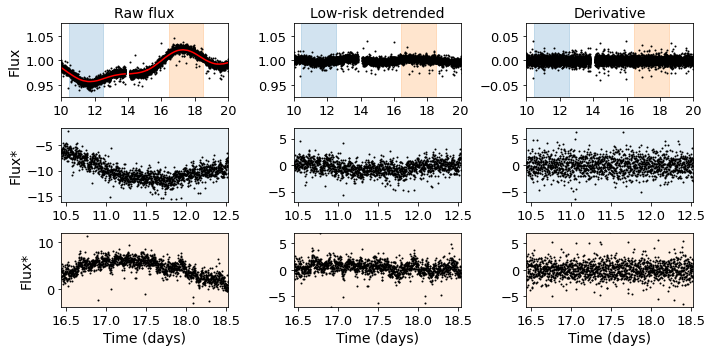

In [150]:
titles=["Raw flux", "Low-risk detrended", "Derivative"]
plt.figure(figsize=(10,5))
for i, fl in enumerate(fluxes):
    
    plt.subplot(3,3,i+1)
    plt.title(titles[i], fontsize=14)
    for j, sp_t in enumerate(spans):
        plt.axvspan(sp_t, sp_t+span_t, alpha=0.2, zorder=-1, color=cs[j])
    vis.plot(lc["time"], fl)
    vis.plot(lc["time"], lc["trend"], scatter=0, c="red", s=1.5) if i==0 else None
    
    plt.xlim(10,20)
    plt.ylim(0.925, 1.075) if i != 2 else plt.ylim(0.925-1, 1.075-1)
    plt.ylabel("Flux", fontsize=14) if i==0 else None
    plt.xticks(fontsize=13)
    
    for j, sp_t in enumerate(spans):
        plt.subplot(3,3,i+1+(j+1)*3)
        plt.axvspan(sp_t, sp_t+span_t, alpha=0.1, zorder=-1, color=cs[j])
        plt.xlim(sp_t, sp_t+span_t)
        msk = (lc["time"]>=sp_t) & (lc["time"]<=sp_t+span_t)
        if i != 2:
            vis.plot(lc["time"][msk], (fl[msk]-1)/sigma)
            
        else:
            vis.plot(lc["time"][msk], fl[msk]/sigma)
        plt.ylim(-7,7) if i!=0 else None
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel("Time (days)", fontsize=14) if j==1 else None
        plt.ylabel("Flux*", fontsize=14) if i==0 else None
#     plt.show()
plt.tight_layout()

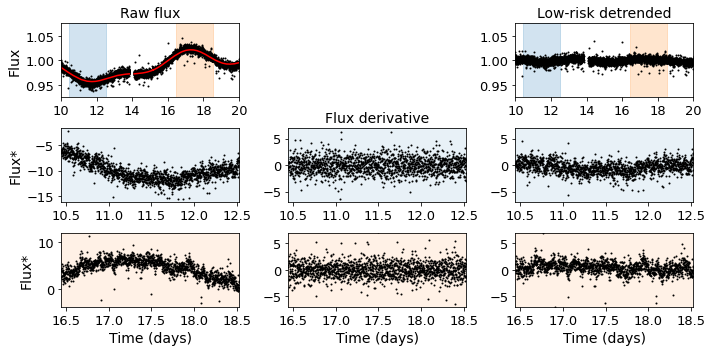

In [159]:
titles=["Raw flux", "Flux derivative", "Low-risk detrended"]
plt.figure(figsize=(10,5))
for i, fl in enumerate(fluxes2):
    if i!=1:
        plt.subplot(3,3,i+1)
        plt.title(titles[i], fontsize=14)
        for j, sp_t in enumerate(spans):
            plt.axvspan(sp_t, sp_t+span_t, alpha=0.2, zorder=-1, color=cs[j])
        vis.plot(lc["time"], fl)
        vis.plot(lc["time"], lc["trend"], scatter=0, c="red", s=1.5) if i==0 else None

        plt.xlim(10,20)
        plt.ylim(0.925, 1.075) if i != 1 else plt.ylim(0.925-1, 1.075-1)
        plt.ylabel("Flux", fontsize=14) if i==0 else None
        plt.xticks(fontsize=13)
    
    for j, sp_t in enumerate(spans):
        plt.subplot(3,3,i+1+(j+1)*3)
        plt.title(titles[i], fontsize=14) if i==1 and j==0 else None
        plt.axvspan(sp_t, sp_t+span_t, alpha=0.1, zorder=-1, color=cs[j])
        plt.xlim(sp_t, sp_t+span_t)
        msk = (lc["time"]>=sp_t) & (lc["time"]<=sp_t+span_t)
        if i != 1:
            vis.plot(lc["time"][msk], (fl[msk]-1)/sigma)
        else:
            vis.plot(lc["time"][msk], fl[msk])
        plt.ylim(-7,7) if i!=0 else None
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel("Time (days)", fontsize=14) if j==1 else None
        plt.ylabel("Flux*", fontsize=14) if i==0 else None
#     plt.show()
plt.tight_layout()

In [56]:
np.nanstd(fl_)

0.003959913490067476